# Predict Future Sales

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

Data fields\
ID - an Id that represents a (Shop, Item) tuple within the test set\
shop_id - unique identifier of a shop\
item_id - unique identifier of a product\
item_category_id - unique identifier of item category\
item_cnt_day - number of products sold. You are predicting a monthly amount of this measure\
item_price - current price of an item\
date - date in format dd/mm/yyyy
date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33\
item_name - name of item\
shop_name - name of shop\
item_category_name - name of item category

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import xgboost as xgb
import matplotlib.pyplot as plt 

## Data Description

In [61]:
df_sales_train = pd.read_csv('sales_train.csv')
df_test = pd.read_csv('test.csv') 
sample_submission = pd.read_csv('sample_submission.csv')
df_items = pd.read_csv('items.csv') 
df_item_categories = pd.read_csv('item_categories.csv') 
df_shops = pd.read_csv('shops.csv') 

## Data Preprocessing

In [62]:
print(df_sales_train.shape)
df_sales_train.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [63]:
df_sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [64]:
df_sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [65]:
df_sales_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [66]:
# date_block_num is colums, item_cnt_day is values
df = df_sales_train.groupby(['date_block_num','shop_id','item_id']).sum()
df = df.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day', fill_value=0)
df.reset_index(inplace=True)
df

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424119,59,22154,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424120,59,22155,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
424121,59,22162,0,0,0,0,0,0,0,0,...,0,9,4,1,1,0,0,1,0,0
424122,59,22164,0,0,0,0,0,0,0,0,...,0,2,1,2,0,0,1,0,0,0


In [67]:
df_test = df_test.merge(df, on=['shop_id', 'item_id'], how = 'left').drop('ID', 1)
df_test.fillna(0, inplace=True)

In [68]:
X_train = df.drop(33, 1)
y_train = df[33]
X_test = df_test.drop(0,1)
X_test_fin = X_test = df_test.drop(0,1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(424124, 35)
(424124,)
(214200, 35)


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print (X_train.shape,  y_train.shape)
print (X_test.shape,  y_test.shape)

(339299, 35) (339299,)
(84825, 35) (84825,)


In [70]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_test_fin = scaler.transform(X_test_fin)

## XGBRegressor 

In [71]:
model1 = xgb.XGBRegressor() #colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8, subsample=0.8, 
                        # gamma=10, learning_rate=0.1, max_depth=12, min_child_weight=1, 
                         #n_estimators=500, random_state=27, reg_alpha=50, reg_lambda=200

In [72]:
model1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [73]:
y_pred1 = model1.predict(X_test)

D:\Users\DZHALIL\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [74]:
print ('Coefficient of determination (R^2):',r2_score(y_test, y_pred1))
print ('Mean squared error (MSE):',mean_squared_error(y_test, y_pred1))
print ('Mean absolute error (MAE):',mean_absolute_error(y_test, y_pred1))

Coefficient of determination (R^2): 0.2079860274315326
Mean squared error (MSE): 1.534861993083429
Mean absolute error (MAE): 0.1902081456821922


In [75]:
predictions1 = model1.predict(X_test_fin)

D:\Users\DZHALIL\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [76]:
sub = sample_submission.copy()
sub['item_cnt_month'] = predictions1
sub.to_csv('result1.csv', index=False)
sub

,ID,item_cnt_month
0,0,0.408981
1,1,0.099022
2,2,0.775970
3,3,0.131626
4,4,0.099022
...,...,...
214195,214195,0.187579
214196,214196,0.089284
214197,214197,0.046864
214198,214198,0.079426


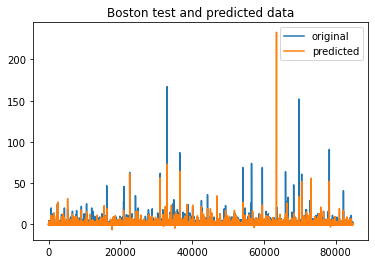

In [77]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred1, label="predicted")

plt.title("Boston test and predicted data")

plt.legend()
plt.show()

## RandomForestRegressor

In [78]:
model2 = RandomForestRegressor() #max_depth = 8, n_estimators = 200

In [79]:
model2.fit(X_train, y_train)

RandomForestRegressor()

In [80]:
y_pred2 = model2.predict(X_test)

In [81]:
print ('Coefficient of determination (R^2):',r2_score(y_test, y_pred2))
print ('Mean squared error (MSE):',mean_squared_error(y_test, y_pred2))
print ('Mean absolute error (MAE):',mean_absolute_error(y_test, y_pred2))

Coefficient of determination (R^2): 0.3543351984748683
Mean squared error (MSE): 1.25124858709107
Mean absolute error (MAE): 0.1625916887709991


In [82]:
predictions2 = model2.predict(X_test_fin)

In [83]:
sub = sample_submission.copy()
sub['item_cnt_month'] = predictions2
sub.to_csv('result2.csv', index=False)
sub

,ID,item_cnt_month
0,0,0.10
1,1,0.67
2,2,0.67
3,3,0.08
4,4,0.68
...,...,...
214195,214195,0.38
214196,214196,1.10
214197,214197,0.06
214198,214198,0.88


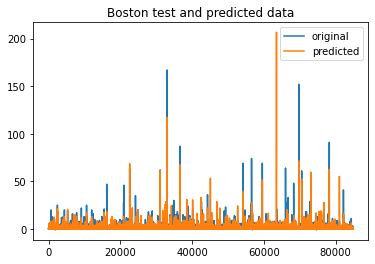

In [84]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred2, label="predicted")

plt.title("Boston test and predicted data")

plt.legend()
plt.show()

## GradientBoostingRegressor

In [85]:
model3 = GradientBoostingRegressor() #n_estimators=500

In [86]:
model3.fit(X_train, y_train)

GradientBoostingRegressor()

In [87]:
y_pred3 = model3.predict(X_test)

In [88]:
print ('Coefficient of determination (R^2):',r2_score(y_test, y_pred3))
print ('Mean squared error (MSE):',mean_squared_error(y_test, y_pred3))
print ('Mean absolute error (MAE):',mean_absolute_error(y_test, y_pred3))

Coefficient of determination (R^2): -0.45937873024827636
Mean squared error (MSE): 2.828163421547208
Mean absolute error (MAE): 0.22290815487510365


In [89]:
predictions3 = model3.predict(X_test_fin)

In [90]:
sub = sample_submission.copy()
sub['item_cnt_month'] = predictions3
sub.to_csv('result3.csv', index=False)
sub

,ID,item_cnt_month
0,0,0.428503
1,1,0.104002
2,2,0.922120
3,3,0.130552
4,4,0.104002
...,...,...
214195,214195,0.240647
214196,214196,0.085231
214197,214197,0.085231
214198,214198,0.085231


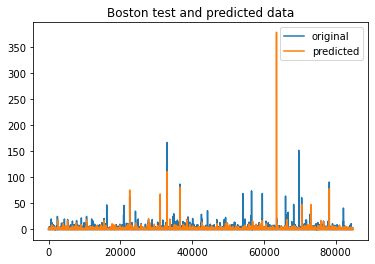

In [91]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred3, label="predicted")

plt.title("Boston test and predicted data")

plt.legend()
plt.show()

## CatBoost

In [92]:
model4 = CatBoostRegressor() #logging_level='Silent', random_state=45, early_stopping_rounds=300

In [93]:
model4.fit(X_train, y_train)

Learning rate set to 0.110114
0:	learn: 4.3153630	total: 31.8ms	remaining: 31.8s
1:	learn: 4.2088906	total: 60ms	remaining: 29.9s
2:	learn: 4.1050585	total: 89.7ms	remaining: 29.8s
3:	learn: 4.0046209	total: 118ms	remaining: 29.3s
4:	learn: 3.9079731	total: 142ms	remaining: 28.3s
5:	learn: 3.8149952	total: 171ms	remaining: 28.3s
6:	learn: 3.7242434	total: 201ms	remaining: 28.6s
7:	learn: 3.6361378	total: 231ms	remaining: 28.6s
8:	learn: 3.5506355	total: 259ms	remaining: 28.5s
9:	learn: 3.4679186	total: 288ms	remaining: 28.5s
10:	learn: 3.3880960	total: 317ms	remaining: 28.5s
11:	learn: 3.3108381	total: 346ms	remaining: 28.5s
12:	learn: 3.2367349	total: 374ms	remaining: 28.4s
13:	learn: 3.1638651	total: 402ms	remaining: 28.3s
14:	learn: 3.0938793	total: 428ms	remaining: 28.1s
15:	learn: 3.0258728	total: 457ms	remaining: 28.1s
16:	learn: 2.9589299	total: 483ms	remaining: 27.9s
17:	learn: 2.8956605	total: 512ms	remaining: 27.9s
18:	learn: 2.8345279	total: 538ms	remaining: 27.8s
19:	learn:

163:	learn: 1.1496381	total: 4.99s	remaining: 25.4s
164:	learn: 1.1494833	total: 5.02s	remaining: 25.4s
165:	learn: 1.1485665	total: 5.05s	remaining: 25.4s
166:	learn: 1.1474508	total: 5.08s	remaining: 25.3s
167:	learn: 1.1467612	total: 5.11s	remaining: 25.3s
168:	learn: 1.1467113	total: 5.14s	remaining: 25.3s
169:	learn: 1.1466626	total: 5.17s	remaining: 25.3s
170:	learn: 1.1460921	total: 5.21s	remaining: 25.2s
171:	learn: 1.1457177	total: 5.24s	remaining: 25.2s
172:	learn: 1.1456463	total: 5.26s	remaining: 25.2s
173:	learn: 1.1449604	total: 5.3s	remaining: 25.2s
174:	learn: 1.1440597	total: 5.33s	remaining: 25.2s
175:	learn: 1.1439530	total: 5.37s	remaining: 25.1s
176:	learn: 1.1436974	total: 5.4s	remaining: 25.1s
177:	learn: 1.1430440	total: 5.43s	remaining: 25.1s
178:	learn: 1.1420040	total: 5.46s	remaining: 25.1s
179:	learn: 1.1414592	total: 5.5s	remaining: 25s
180:	learn: 1.1413578	total: 5.53s	remaining: 25s
181:	learn: 1.1407771	total: 5.56s	remaining: 25s
182:	learn: 1.1403913

326:	learn: 1.0657614	total: 10.2s	remaining: 21s
327:	learn: 1.0655242	total: 10.2s	remaining: 20.9s
328:	learn: 1.0642606	total: 10.3s	remaining: 20.9s
329:	learn: 1.0642509	total: 10.3s	remaining: 20.9s
330:	learn: 1.0640559	total: 10.3s	remaining: 20.9s
331:	learn: 1.0638101	total: 10.4s	remaining: 20.8s
332:	learn: 1.0635755	total: 10.4s	remaining: 20.8s
333:	learn: 1.0635530	total: 10.4s	remaining: 20.8s
334:	learn: 1.0634701	total: 10.4s	remaining: 20.7s
335:	learn: 1.0632589	total: 10.5s	remaining: 20.7s
336:	learn: 1.0602343	total: 10.5s	remaining: 20.7s
337:	learn: 1.0601559	total: 10.5s	remaining: 20.7s
338:	learn: 1.0600042	total: 10.6s	remaining: 20.6s
339:	learn: 1.0586493	total: 10.6s	remaining: 20.6s
340:	learn: 1.0584353	total: 10.6s	remaining: 20.6s
341:	learn: 1.0568765	total: 10.7s	remaining: 20.5s
342:	learn: 1.0568554	total: 10.7s	remaining: 20.5s
343:	learn: 1.0562206	total: 10.7s	remaining: 20.5s
344:	learn: 1.0553093	total: 10.8s	remaining: 20.5s
345:	learn: 1.

487:	learn: 1.0294398	total: 15.4s	remaining: 16.1s
488:	learn: 1.0292997	total: 15.4s	remaining: 16.1s
489:	learn: 1.0292507	total: 15.5s	remaining: 16.1s
490:	learn: 1.0291613	total: 15.5s	remaining: 16.1s
491:	learn: 1.0290738	total: 15.5s	remaining: 16s
492:	learn: 1.0289785	total: 15.6s	remaining: 16s
493:	learn: 1.0283653	total: 15.6s	remaining: 16s
494:	learn: 1.0282327	total: 15.6s	remaining: 15.9s
495:	learn: 1.0281061	total: 15.7s	remaining: 15.9s
496:	learn: 1.0279429	total: 15.7s	remaining: 15.9s
497:	learn: 1.0276875	total: 15.7s	remaining: 15.8s
498:	learn: 1.0276314	total: 15.8s	remaining: 15.8s
499:	learn: 1.0273065	total: 15.8s	remaining: 15.8s
500:	learn: 1.0272436	total: 15.8s	remaining: 15.7s
501:	learn: 1.0270731	total: 15.8s	remaining: 15.7s
502:	learn: 1.0270412	total: 15.9s	remaining: 15.7s
503:	learn: 1.0269171	total: 15.9s	remaining: 15.7s
504:	learn: 1.0268310	total: 15.9s	remaining: 15.6s
505:	learn: 1.0268011	total: 16s	remaining: 15.6s
506:	learn: 1.026716

648:	learn: 1.0106208	total: 20.6s	remaining: 11.1s
649:	learn: 1.0105628	total: 20.6s	remaining: 11.1s
650:	learn: 1.0105225	total: 20.7s	remaining: 11.1s
651:	learn: 1.0104407	total: 20.7s	remaining: 11.1s
652:	learn: 1.0104127	total: 20.7s	remaining: 11s
653:	learn: 1.0103752	total: 20.8s	remaining: 11s
654:	learn: 1.0103433	total: 20.8s	remaining: 11s
655:	learn: 1.0103214	total: 20.8s	remaining: 10.9s
656:	learn: 1.0102612	total: 20.9s	remaining: 10.9s
657:	learn: 1.0102371	total: 20.9s	remaining: 10.9s
658:	learn: 1.0101974	total: 20.9s	remaining: 10.8s
659:	learn: 1.0101823	total: 21s	remaining: 10.8s
660:	learn: 1.0099381	total: 21s	remaining: 10.8s
661:	learn: 1.0098819	total: 21s	remaining: 10.7s
662:	learn: 1.0098476	total: 21.1s	remaining: 10.7s
663:	learn: 1.0098381	total: 21.1s	remaining: 10.7s
664:	learn: 1.0096888	total: 21.1s	remaining: 10.6s
665:	learn: 1.0096569	total: 21.2s	remaining: 10.6s
666:	learn: 1.0094724	total: 21.2s	remaining: 10.6s
667:	learn: 1.0094338	to

807:	learn: 0.9974582	total: 25.7s	remaining: 6.1s
808:	learn: 0.9973911	total: 25.7s	remaining: 6.07s
809:	learn: 0.9973580	total: 25.7s	remaining: 6.04s
810:	learn: 0.9973423	total: 25.8s	remaining: 6.01s
811:	learn: 0.9972836	total: 25.8s	remaining: 5.98s
812:	learn: 0.9972391	total: 25.8s	remaining: 5.94s
813:	learn: 0.9972143	total: 25.9s	remaining: 5.91s
814:	learn: 0.9971742	total: 25.9s	remaining: 5.88s
815:	learn: 0.9971310	total: 25.9s	remaining: 5.85s
816:	learn: 0.9970981	total: 26s	remaining: 5.82s
817:	learn: 0.9970683	total: 26s	remaining: 5.78s
818:	learn: 0.9970224	total: 26s	remaining: 5.75s
819:	learn: 0.9969835	total: 26.1s	remaining: 5.72s
820:	learn: 0.9969376	total: 26.1s	remaining: 5.69s
821:	learn: 0.9968672	total: 26.1s	remaining: 5.65s
822:	learn: 0.9968396	total: 26.1s	remaining: 5.62s
823:	learn: 0.9967996	total: 26.2s	remaining: 5.59s
824:	learn: 0.9967868	total: 26.2s	remaining: 5.56s
825:	learn: 0.9967741	total: 26.2s	remaining: 5.52s
826:	learn: 0.99674

967:	learn: 0.9885162	total: 30.8s	remaining: 1.02s
968:	learn: 0.9884873	total: 30.8s	remaining: 985ms
969:	learn: 0.9884752	total: 30.8s	remaining: 953ms
970:	learn: 0.9884519	total: 30.9s	remaining: 922ms
971:	learn: 0.9884357	total: 30.9s	remaining: 890ms
972:	learn: 0.9884288	total: 30.9s	remaining: 858ms
973:	learn: 0.9884087	total: 31s	remaining: 826ms
974:	learn: 0.9883671	total: 31s	remaining: 795ms
975:	learn: 0.9883516	total: 31s	remaining: 763ms
976:	learn: 0.9883370	total: 31s	remaining: 731ms
977:	learn: 0.9883255	total: 31.1s	remaining: 699ms
978:	learn: 0.9882739	total: 31.1s	remaining: 667ms
979:	learn: 0.9882481	total: 31.1s	remaining: 636ms
980:	learn: 0.9882350	total: 31.2s	remaining: 604ms
981:	learn: 0.9882101	total: 31.2s	remaining: 572ms
982:	learn: 0.9881817	total: 31.2s	remaining: 540ms
983:	learn: 0.9881262	total: 31.3s	remaining: 508ms
984:	learn: 0.9876336	total: 31.3s	remaining: 477ms
985:	learn: 0.9875997	total: 31.3s	remaining: 445ms
986:	learn: 0.987562

In [94]:
y_pred4 = model4.predict(X_test)

In [95]:
print ('Coefficient of determination (R^2):',r2_score(y_test, y_pred4))
print ('Mean squared error (MSE):',mean_squared_error(y_test, y_pred4))
print ('Mean absolute error (MAE):',mean_absolute_error(y_test, y_pred4))

Coefficient of determination (R^2): -0.851688785812311
Mean squared error (MSE): 3.588430051486785
Mean absolute error (MAE): 0.2098275928992172


In [96]:
predictions4 = model4.predict(X_test_fin)

In [97]:
sub = sample_submission.copy()
sub['item_cnt_month'] = predictions4
sub.to_csv('result4.csv', index=False)
sub

,ID,item_cnt_month
0,0,0.442823
1,1,0.135202
2,2,0.735450
3,3,0.148286
4,4,0.135202
...,...,...
214195,214195,0.150931
214196,214196,0.112802
214197,214197,-0.021243
214198,214198,0.103518


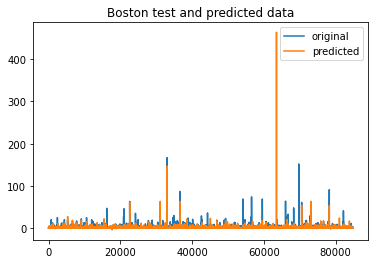

In [98]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred4, label="predicted")

plt.title("Boston test and predicted data")

plt.legend()
plt.show()